# Загрузка Pandas и очистка данных

In [1590]:
import pandas as pd
import numpy as np
from ast import literal_eval
from datetime import datetime as dt

In [1591]:
# Прочитаем датасет
df = pd.read_csv('main_task.csv')

In [1592]:
# Заменим наименование столбцов для более удобной работы
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking',
              'rating', 'price_range', 'reviews_number', 'reviews', 'url_ta', 'id_ta']

In [1593]:
# Посмотрим на информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   restaurant_id   40000 non-null  object 
 1   city            40000 non-null  object 
 2   cuisine_style   30717 non-null  object 
 3   ranking         40000 non-null  float64
 4   rating          40000 non-null  float64
 5   price_range     26114 non-null  object 
 6   reviews_number  37457 non-null  float64
 7   reviews         40000 non-null  object 
 8   url_ta          40000 non-null  object 
 9   id_ta           40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [1594]:
# Обнаружены пропуски в столбце Number of Reviews. Можно сделать предположение, что если
# в столбце reviews указан пустой список, значит количество отзывов = 0. Заменим такие пропуски.
# df[df.reviews_number.isna() & (df.reviews == '[[], []]')].loc[:,('reviews_number')] = 0
df.loc[df.reviews_number.isna() & (df.reviews == '[[], []]'),
       'reviews_number'] = 0

In [1595]:
# Дальше мы можем предположить, что если в столбце reviews представлена информация только
# об одном отзыве, то количество отзывов = 1. Заменим такие пропуски.
# df[df.reviews_number.isna() & (df.reviews.str.match('^\[\[\'.*\'\],\s?\[\'.*\'\]\]$'))] = 1
df.loc[df.reviews_number.isna() & (df.reviews.str.match(
    '^\[\[\'.*\'\],\s?\[\'.*\'\]\]$')), 'reviews_number'] = 1

In [1596]:
# Проверим, что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   restaurant_id   40000 non-null  object 
 1   city            40000 non-null  object 
 2   cuisine_style   30717 non-null  object 
 3   ranking         40000 non-null  float64
 4   rating          40000 non-null  float64
 5   price_range     26114 non-null  object 
 6   reviews_number  39972 non-null  float64
 7   reviews         40000 non-null  object 
 8   url_ta          40000 non-null  object 
 9   id_ta           40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [1597]:
# Т.о. осталось только 28 пропусков в столбце reviews_number, заменим их средним значением
df.fillna(value={'reviews_number': df.reviews_number.mean()}, inplace=True)

In [1598]:
# Поскольку показатель ranking зависит от общего количества ресторанов в городе, то можно
# представить его в виде относительной величины как отношение к максимальному по городу
groups_by_cities = df.groupby('city').ranking.max()
df.ranking = df.apply(lambda x: x.ranking/groups_by_cities[x.city], axis=1)

In [1599]:
# У нас есть категориальный признак cuisine_style, создадим на его основе dummy признаки
# При этом уменьшим количество значений этого признака, переимновав такие значения в Other
df_styles = df.cuisine_style.fillna('[]').apply(lambda x: literal_eval(x))
all_cuisine_styles = []
for style in df_styles:
    all_cuisine_styles += style
cuisine_styles = set(all_cuisine_styles)
cuisine_styles_new = set()
for style in cuisine_styles:
    freq = df.cuisine_style.str.contains(style).sum()
    if freq < 100:
        df.cuisine_style = df.cuisine_style.replace(style, 'Other')
        cuisine_styles_new.add('Other')
    else:
        cuisine_styles_new.add(style)
for style in cuisine_styles_new:
    df[style] = df.cuisine_style.fillna('').apply(
        lambda x: 1 if style in x else 0)

In [1600]:
# Создадим также dummy признаки для второго категориального признака - city
df = df.join(pd.get_dummies(df.city))

In [1601]:
# Приведем показатель price_range к числовому значению и заменим пропуски на среднее значение
df.price_range = df.price_range.replace('$', 1)
df.price_range = df.price_range.replace('$$ - $$$', 2)
df.price_range = df.price_range.replace('$$$$', 3)
df.price_range.fillna(df.price_range.mean(), inplace=True)

In [1602]:
# Посчитаем сколько дней прошло с момента последнего отзыва и добавим эти данные в качестве нового признака.
# При этом будем исходить из предположения, что датой составления датасета является максимальная дата отзыва
# из всего датасета. Также предположим, что если отзывов нет, эта цифра равна среднему количеству дней
# в датасете.
df.reviews = df.reviews.apply(lambda x: literal_eval(x.replace('nan', "''")))
df['review1_date'] = df.reviews.apply(lambda x: x[1][0] if len(x[1]) else '')
df['review2_date'] = df.reviews.apply(
    lambda x: x[1][1] if len(x[1]) > 1 else '')
df.review1_date = pd.to_datetime(df.review1_date)
df.review2_date = pd.to_datetime(df.review2_date)
df['last_review_date'] = df.apply(
    lambda x: x.review1_date if x.review1_date > x.review2_date else x.review2_date, axis=1)
last_date = df.last_review_date.max()
df['last_review_days'] = df.apply(lambda x: (
    last_date - x.last_review_date).days, axis=1)
df.last_review_days = df.last_review_days.fillna(df.last_review_days.mean())

In [1603]:
# Добавим новый признак, показывающий сколько дней прошло между двумя представленными в датасете отзывами
# и заполним максимальным значением те строки, где двух отзывов нет
df['interval'] = df.apply(lambda x: abs(
    (x.review1_date - x.review2_date).days), axis=1)
df.interval.fillna(df.interval.max(), inplace=True)

array([[<AxesSubplot:title={'center':'interval'}>,
        <AxesSubplot:title={'center':'last_review_days'}>],
       [<AxesSubplot:title={'center':'reviews_number'}>,
        <AxesSubplot:title={'center':'ranking'}>],
       [<AxesSubplot:title={'center':'price_range'}>, <AxesSubplot:>]],
      dtype=object)

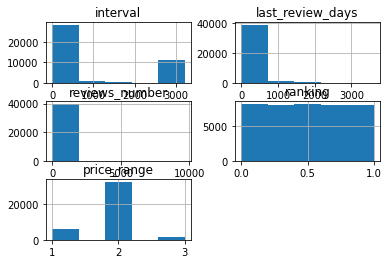

In [1604]:
# Посмотрим на распределение некоторых числовых признаков
df[['interval', 'last_review_days', 'reviews_number',
    'ranking', 'price_range']].hist(bins=5)

<AxesSubplot:>

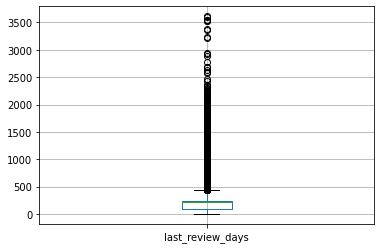

In [1605]:
# for feature in ['last_review_days', 'reviews_number', 'ranking', 'interval']:
df.boxplot(column='last_review_days')

<AxesSubplot:>

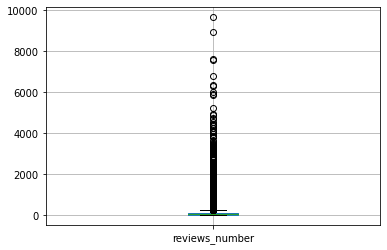

In [1606]:
df.boxplot(column='reviews_number')

<AxesSubplot:>

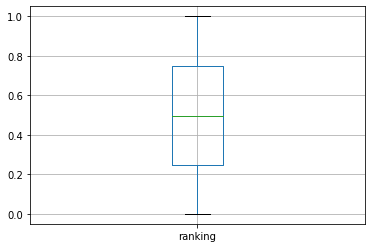

In [1607]:
df.boxplot(column='ranking')

<AxesSubplot:>

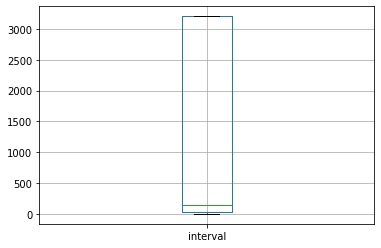

In [1608]:
df.boxplot(column='interval')

<AxesSubplot:>

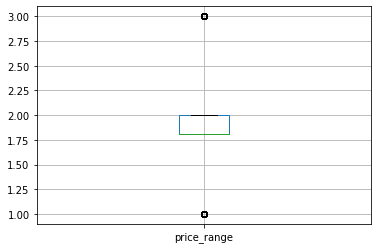

In [1609]:
df.boxplot(column='price_range')

In [1610]:
# Можно было бы посчитать по признаку reviews_number значения более 6000 и по признаку last_review_days
# значения более 3000 выбросами, однако проведенные тесты показали, что их удаление не
# приводит к улучшению точности модели.

In [1611]:
# Распределение признаков interval и last_review_days не выглядит нормальным, однако оно обусловлено
# большим количеством отсутствующих данных, которые мы были вынуждены заменить исходя из
# наших предположений.

In [1612]:
# Удалим все нечисловые столбцы
df.drop(['review1_date', 'review2_date',
         'last_review_date'], axis=1, inplace=True)
for col in df:
    if df[col].dtype == np.object:
        df.drop(columns=[col], inplace=True)

In [1613]:
# Посмотрим на корреляцию признаков.
df[['rating', 'last_review_days', 'ranking',
    'reviews_number', 'interval', 'price_range']].corr()

,rating,last_review_days,ranking,reviews_number,interval,price_range
rating,1.000000,-0.078836,-0.544573,0.026882,-0.024333,-0.015376
last_review_days,-0.078836,1.000000,0.317234,-0.192401,0.032577,-0.042699
ranking,-0.544573,0.317234,1.000000,-0.405765,0.417785,-0.147823
reviews_number,0.026882,-0.192401,-0.405765,1.000000,-0.246724,0.166896
interval,-0.024333,0.032577,0.417785,-0.246724,1.000000,-0.052576
price_range,-0.015376,-0.042699,-0.147823,0.166896,-0.052576,1.000000


In [1614]:
# Из таблицы мы видим, что силно скоррелированных признаков нет, а значит наш датасет пригоден
# для обучения модели

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели, нормализация данных

In [1615]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
# Проведем нормализацию наших признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df.drop(['rating'], axis=1)
scaler.fit_transform(df)
y = df['rating']

/home/alex/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/alex/.local/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [1616]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [1617]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [1618]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [1619]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [1620]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2075275


In [1622]:
# В результате преобразований, удалось снизить отклонение предсказания более чем в раза.